Web Scraping experiments

In [1]:
%pip install requests beautifulsoup4 pandas pyarrow

Note: you may need to restart the kernel to use updated packages.


Let's explore a fundamental example of web scraping by extracting lottery numbers from a lottery website and then saving this data in a Parquet file. We can use this dataset for various purposes, such as training a machine learning model to predict winning numbers.

## Step 1: Web Scraping

To begin, we'll utilize web scraping techniques to retrieve the latest lottery numbers from a specific lottery website. Web scraping involves extracting information from web pages programmatically. In this case, we are interested in the lottery numbers, which are typically displayed on the website.

## Step 2: Data Extraction

Once we've collected the lottery numbers from the website, we need to extract and structure this data. This involves parsing the HTML content of the webpage to locate the relevant information and then storing it in a structured format, such as a Python dictionary or a pandas DataFrame.


In [2]:
# imports
import pandas as pd
import numpy
from src.game import Game
from src.utils import scrape_lottery_data
from src.utils import read_all_parquet_files

In [3]:
# declare constants

# extracted date format
DATE_FORMAT = "%a, %b %d, %Y"

# years to process
YEARS_TO_PROCESS = [2023, 2022, 2021, 2020, 2019]

# dataset filename
DATASET_LOCAL_COPY = './static/data/'

In [4]:
# declare a dataframe for storing game results 
dtypes = numpy.dtype(
    [
        ('Date', 'datetime64[ns]'),
        ('Ball_1', numpy.float64),
        ('Ball_2',numpy.float64),
        ('Ball_3',numpy.float64),
        ('Ball_4',numpy.float64),
        ('Ball_5',numpy.float64),
        ('Ball_Bonus',numpy.float64),
        ]
    )

games_df = pd.DataFrame(numpy.empty(0, dtype=dtypes))

In [5]:
# for all years we want to process 
for year in YEARS_TO_PROCESS:
  # get the data for this year
  scrape_lottery_data(year, DATASET_LOCAL_COPY, DATE_FORMAT)

In [6]:
# get all the files 
all_games = read_all_parquet_files(DATASET_LOCAL_COPY)

if all_games is not None:
    # Let us examine what we have
    print(all_games.head())

        Date Ball_1 Ball_2 Ball_3 Ball_4 Ball_5 Ball_Bonus  Date_Converted
0 2019-12-28     20     23     39     59     60         18             NaN
1 2019-12-25     02     04     16     30     46         20             NaN
2 2019-12-21     19     31     35     50     67         14             NaN
3 2019-12-18     14     18     26     39     68         09             NaN
4 2019-12-14     03     06     12     32     64         19             NaN


In [10]:
# display dataframe's summary statistics including all collumns
all_games.describe(include='all')

,Date,Ball_1,Ball_2,Ball_3,Ball_4,Ball_5,Ball_Bonus,Date_Converted
count,599,1198.0,1198.0,1198,1198.0,1198.0,599,5.990000e+02
unique,NaN,88.0,108.0,118,110.0,90.0,26,NaN
top,NaN,2.0,21.0,37,55.0,69.0,18,NaN
freq,NaN,47.0,28.0,26,24.0,44.0,38,NaN
mean,2021-08-03 00:28:50.884807936,NaN,NaN,NaN,NaN,NaN,NaN,1.627951e+09
min,2019-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.546387e+09
25%,2020-06-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.591574e+09
50%,2021-10-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.634342e+09
75%,2022-09-29 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.664453e+09
max,2023-09-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.694563e+09


We can confirm range of the downloaded data [2019, 2023]

## Step 3: Data Cleaning and Preprocessing

Data obtained through web scraping may require cleaning and preprocessing. This can involve handling missing values, removing duplicates, and converting data types to ensure it's ready for analysis and model training.

In [11]:
# reset index
all_games.reset_index(drop=True, inplace=True)
all_games.set_index('Date', inplace=True)

# change datatypes
#all_games['Date_Converted'] = all_games['Date'].apply(lambda x: x.timestamp())
all_games['Ball_1'] = all_games['Ball_1'].astype('float64')
all_games['Ball_2'] = all_games['Ball_2'].astype('float64')
all_games['Ball_3'] = all_games['Ball_3'].astype('float64')
all_games['Ball_4'] = all_games['Ball_4'].astype('float64')
all_games['Ball_5'] = all_games['Ball_5'].astype('float64')
all_games['Ball_Bonus'] = all_games['Ball_Bonus'].astype('float64')

original = all_games

# let us savbe it for now 
#all_games = all_games.drop('Ball_Bonus', axis=1)

## Step 4: Data Storage

Now that we have our clean and structured dataset, we'll save it in a Parquet file format. Parquet is a columnar storage format that's highly efficient for analytics and machine learning. It supports compression and works well with various data processing tools and frameworks.

In [12]:
# store prepared dataset
all_games.to_parquet(f'{DATASET_LOCAL_COPY}_all_games.parquet')

## Step 5: Exploratory Data Analysis (EDA)

Before diving into model training, it's a good practice to perform exploratory data analysis. This step involves visualizing the data, calculating summary statistics, and gaining insights into the distribution and patterns of lottery numbers.

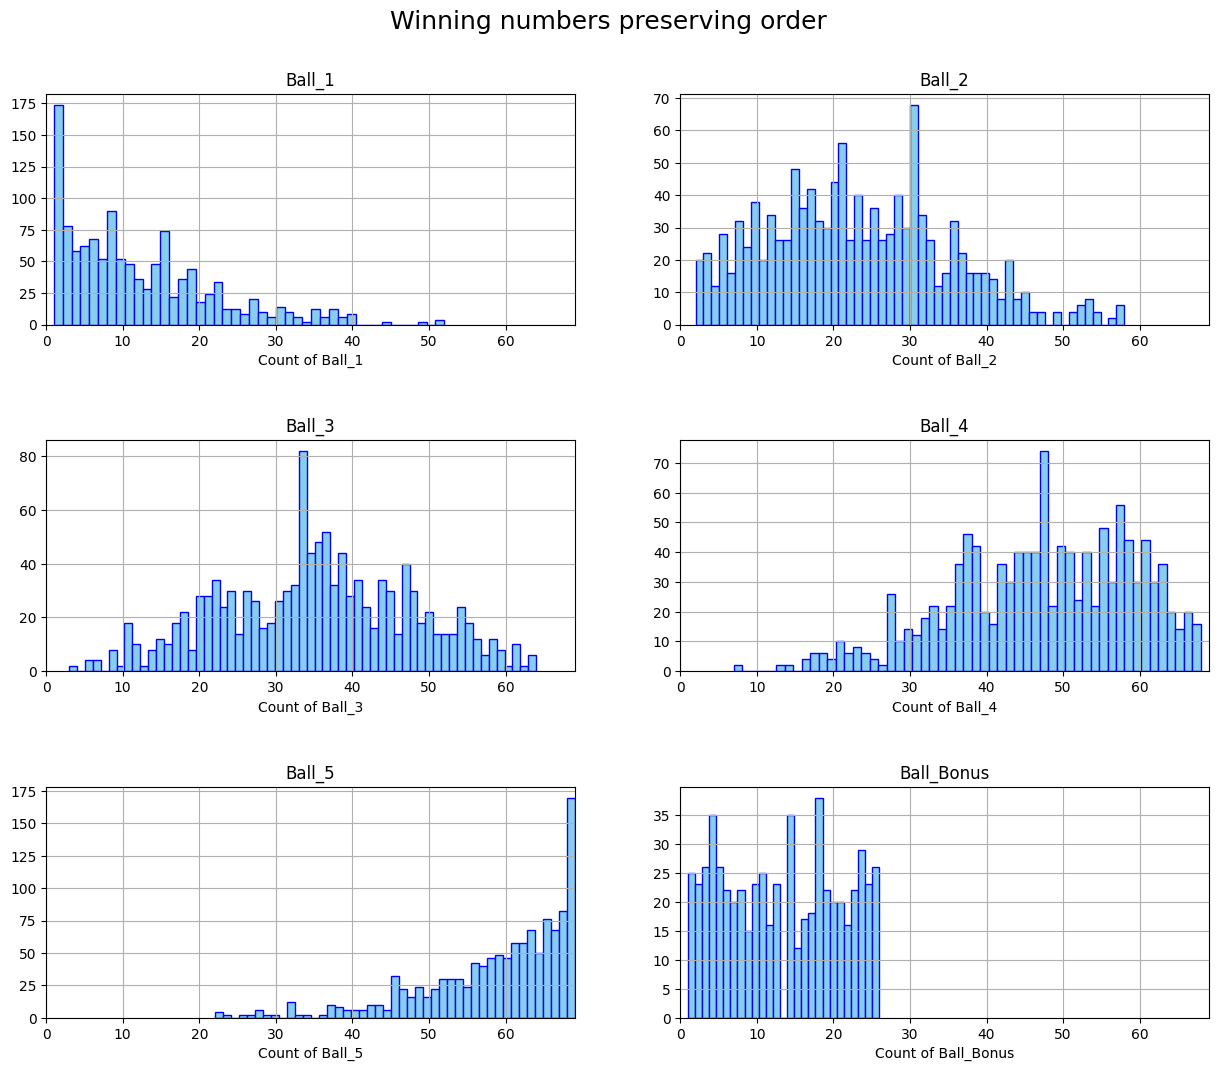

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Winning numbers preserving order", fontsize=18, y=0.95)

# loop through tickers andaxes
number_order = ['Ball_1', 'Ball_2', 'Ball_3', 'Ball_4', 'Ball_5', 'Ball_Bonus']
for number_order, ax in zip(number_order, axs.ravel()):
    # filter df for ticker and plot on specified axes
    all_games[number_order].hist(ax=ax, bins=len(all_games[number_order].unique()), color='skyblue', ec='blue')
    ax.set_title(number_order)
    ax.set_xlabel("Count of " + number_order)
    ax.set_xlim([0, 69])
plt.show()

## Step 6: Model Development

With the dataset prepared and understood, we can move on to developing a machine learning model. In this case, our goal is to predict future winning numbers based on historical data. We can use various algorithms, such as regression, time series forecasting, or neural networks, depending on the nature of the lottery game and the dataset.

Note: NEXT POST

## Step 7: Model Evaluation and Fine-Tuning

After training the model, we need to evaluate its performance using appropriate metrics. Depending on the results, we may need to fine-tune the model, adjust hyperparameters, or try different algorithms to improve its accuracy and reliability.

Note: NEXT POST



## Step 8: Deployment and Prediction

Once we have a well-performing model, we can deploy it to make predictions on upcoming lottery draws. The model will take historical data as input and provide predictions for future winning numbers.

Note: NEXT POST

## Step 9: Continuous Updates

Lottery numbers change with each draw, so it's essential to continuously update the dataset and retrain the model to ensure its accuracy over time.

In summary, web scraping, data extraction, cleaning, and model development are essential steps in creating a predictive model for lottery numbers. This process allows us to harness historical data to improve our chances of predicting winning numbers in future draws. Storing the data in a Parquet file ensures efficient data handling and analysis.

Note: NEXT POST